In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import yaml

from functools import cache

In [114]:
plt.rcParams.update({
    'figure.figsize': (6, 4),            # Figure size
    'figure.dpi': 100,                   # High DPI for publication-quality images
    'axes.titlesize': 14,                # Title font size
    'axes.labelsize': 12,                # Axis label font size
    'axes.labelpad': 10,                 # Padding for labels
    'axes.linewidth': 1,                 # Axis line width
    'axes.grid': False,                  # Disable grid unless necessary
    'xtick.labelsize': 10,               # X-axis tick label size
    'ytick.labelsize': 10,               # Y-axis tick label size
    'xtick.major.size': 4,               # Length of major ticks
    'ytick.major.size': 4,               # Length of major ticks
    'xtick.major.width': 1,              # Width of major ticks
    'ytick.major.width': 1,              # Width of major ticks
    'xtick.direction': 'in',             # Ticks facing inwards
    'ytick.direction': 'in',             # Ticks facing inwards
    'legend.fontsize': 10,               # Legend font size
    'legend.frameon': False,             # Disable legend frame for a cleaner look
    'font.family': 'serif',              # Use a serif font for text
    'font.serif': ['DejaVu Serif'],      # Use 'DejaVu Serif' as the fallback serif font
    'lines.linewidth': 1.5,              # Line width for plots
    'lines.markersize': 6,               # Marker size
    'savefig.dpi': 300,                  # Save figure resolution
    'savefig.bbox': 'tight',             # Adjust layout to avoid clipping
})

In [115]:
models = [
    'allenai_OLMoE-1B-7B-0924',
    'google_gemma-2-2b',
    'google_gemma-2-2b-it',
    'meta-llama_Llama-3.1-8B',
    'meta-llama_Llama-3.1-8B-Instruct',
    'microsoft_phi-2',
    'mistralai_Mistral-7B-Instruct-v0.3',
    'mistralai_Mistral-7B-v0.3',
]
data_path = '/home/davidchan/Projects/random-needles/posterior_chain_coin_flip/icl_{step}/50/{model}/stats.pkl'

@cache
def load_data(step, model):
    with open(data_path.format(step=step, model=model), 'rb') as f:
        data = pickle.load(f)
    return data

In [116]:
yaml_path = '/home/davidchan/Projects/random-needles/posterior_chain_coin_flip/configs/icl_{step}/bias_50.yaml'

@cache
def load_config_heads(step):
    with open(yaml_path.format(step=step), 'r') as f:
        config = yaml.safe_load(f)
    if config['input_prompt'][0].split()[-2].strip().replace(',', '') == 'heads':
        return True
    return False

In [117]:
load_config_heads(1)

True

In [118]:
from scipy.stats import beta

class BayesianCoinFlipper:
    def __init__(self, alpha=1, beta=1):
        """
        Initialize the BayesianCoinFlipper with a Beta prior Beta(alpha, beta).
        Defaults to an uninformative prior Beta(1,1).
        """
        self.alpha = alpha  # Prior successes (heads)
        self.beta = beta    # Prior failures (tails)

    def add_result(self, result):
        """
        Update the posterior based on the observed result.
        """
        if result == 'H':
            self.alpha += 1
        elif result == 'T':
            self.beta += 1
        else:
            raise ValueError("Result must be 'H' or 'T'")

    def get_posterior_mean(self):
        """
        Returns the posterior mean (expected probability of heads).
        """
        return self.alpha / (self.alpha + self.beta)

    def get_posterior_distribution(self):
        """
        Returns the Beta distribution object representing the posterior.
        """
        return beta(self.alpha, self.beta)

    def __str__(self):
        return f"Beta({self.alpha}, {self.beta}) - Posterior Mean: {self.get_posterior_mean():.3f}"


In [119]:
class BayesianCoinFlipperGamma:
    def __init__(self, alpha=1, beta=1, gamma=0.95):
        """
        Initialize the BayesianCoinFlipper with a Beta prior Beta(alpha, beta).
        Uses an exponential decay factor (gamma) to weight recent observations more.
        """
        self.alpha = alpha  # Prior successes (heads)
        self.beta = beta    # Prior failures (tails)
        self.gamma = gamma  # Decay factor
        self.weighted_alpha = alpha
        self.weighted_beta = beta

    def add_result(self, result):
        """
        Update the posterior using a gamma-decay approach, where older observations
        gradually contribute less to the posterior parameters.
        """
        if result not in ['H', 'T']:
            raise ValueError("Result must be 'H' or 'T'")

        # Apply decay to previous counts
        self.weighted_alpha *= self.gamma
        self.weighted_beta *= self.gamma

        # Add the new observation
        if result == 'H':
            self.weighted_alpha += 1
        else:
            self.weighted_beta += 1

        # Update effective parameters for Beta distribution
        self.alpha = max(1, self.weighted_alpha)
        self.beta = max(1, self.weighted_beta)

    def get_posterior_mean(self):
        """
        Returns the posterior mean (expected probability of heads).
        """
        return self.alpha / (self.alpha + self.beta)

    def get_posterior_distribution(self):
        """
        Returns the Beta distribution object representing the posterior.
        """
        return beta(self.alpha, self.beta)

    def __str__(self):
        return f"Beta({self.alpha:.2f}, {self.beta:.2f}) - Posterior Mean: {self.get_posterior_mean():.3f}"


<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:64: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:64: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1801626/940583609.py:63: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian posterior ($\gamma=0.88$)')
/tmp/ipykernel_1801626/940583609.py:64: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(bayes_posterior_higher, color='blue', linestyle='--', label='Empirical Bayesian posterior ($\gamma=1.0$)')


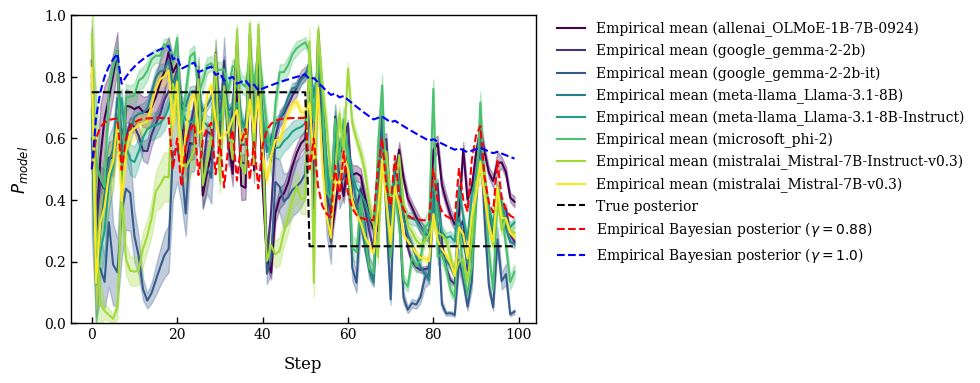

In [157]:
model_data ={}
for model in models:
    points = []
    true_posterior = []
    bayes_posterior = []
    bayes_posterior_higher = []
    flipper = BayesianCoinFlipperGamma(gamma=0.5)
    flipper_higher = BayesianCoinFlipperGamma(gamma=1)
    sequence = []

    for i in range(100):
        x = []
        try:
            for p in load_data(i, model)['stats_over_prompts']:
                x.append(float(list(p['biased_point'].values())[0]['choice_probs'][0]))
        except:
            continue
        if i <= 50:
            true_posterior.append(0.75)
        else:
            # It's a mixture of 0.75 and 0.25
            # true_posterior.append((i - 50) / i * 0.25 + (50 / i) * 0.75)
            true_posterior.append(0.25)

        # Determine if it was a heads or tails, and update the bayesian posterior
        if i == 0:
            bayes_posterior.append(0.5)
            bayes_posterior_higher.append(0.5)
        else:
            if load_config_heads(i):
                flipper.add_result('H')
                flipper_higher.add_result('H')
                sequence.append('H')
            else:
                flipper.add_result('T')
                flipper_higher.add_result('T')
                sequence.append('T')
            bayes_posterior.append(flipper.get_posterior_mean())
            bayes_posterior_higher.append(flipper_higher.get_posterior_mean())

        points.append(x)

    data = np.array(points)
    data_mean = np.mean(data, axis=1)
    data_std = np.std(data, axis=1)

    # Get a color
    color = plt.cm.viridis(np.linspace(0, 1, len(models)))[models.index(model)]

    plt.plot(data_mean, label='Empirical mean ({})'.format(model), color=color)
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, alpha=0.3, color=color)

    model_data[model] = {
        'mean': data_mean,
        'std': data_std,
        'true_posterior': true_posterior,
        'bayes_posterior': bayes_posterior,
        'bayes_posterior_higher': bayes_posterior_higher,
        'sequence': sequence
    }

plt.plot(true_posterior, color='black', linestyle='--', label='True posterior')
plt.plot(bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian posterior ($\gamma=0.88$)')
plt.plot(bayes_posterior_higher, color='blue', linestyle='--', label='Empirical Bayesian posterior ($\gamma=1.0$)')
plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.xlabel('Step')
plt.ylabel('$P_{model}$')
plt.ylim(0, 1)
plt.savefig('posterior_chain_coin_flip.pdf')
plt.show()

In [158]:
# Fit a gamma decay to each model
def fit_quality(model, gamma):
    flipper = BayesianCoinFlipperGamma(gamma=gamma)
    loss = 0
    for i, s in enumerate(model_data[model]['sequence']):
        flipper.add_result(s)
        loss += abs(flipper.get_posterior_mean() - model_data[model]['mean'][i+1])
    return loss

from scipy.optimize import minimize

gamma_fits = {}
for model in models:
    gamma_fits[model] = minimize(lambda x: fit_quality(model, x), x0=[0.5], bounds=[(0, 1)], method='L-BFGS-B')

for model in models:
    print(f"{model}: {gamma_fits[model].x}")

# print()

# gamma_fits = {}
# grid_points = np.linspace(0, 1, 1000)  # Adjust the number of points for precision

# for model in models:
#     best_x = None
#     best_score = float('inf')  # Assuming lower fit_quality is better

#     for x in grid_points:
#         score = fit_quality(model, x)
#         if score < best_score:
#             best_score = score
#             best_x = x

#     gamma_fits[model] = {'x': best_x, 'fit_quality': best_score}

# for model in models:
#     print(f"{model}: {gamma_fits[model]['x']}")

allenai_OLMoE-1B-7B-0924: [0.32681407]
google_gemma-2-2b: [0.49104278]
google_gemma-2-2b-it: [0.30874467]
meta-llama_Llama-3.1-8B: [0.88073904]
meta-llama_Llama-3.1-8B-Instruct: [0.46555915]
microsoft_phi-2: [0.87812599]
mistralai_Mistral-7B-Instruct-v0.3: [0.]
mistralai_Mistral-7B-v0.3: [0.69036618]


/tmp/ipykernel_1801626/3616305943.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(len(bayes_posterior)) + 1, bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian posterior ($\\gamma={:.2f}$)'.format(float(gamma_fits[model].x)))


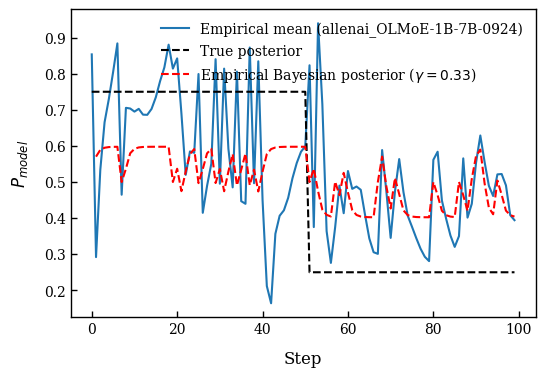

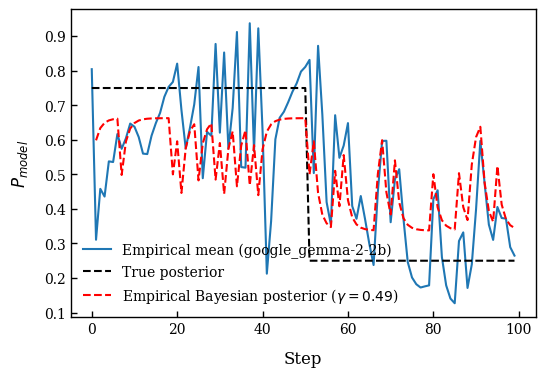

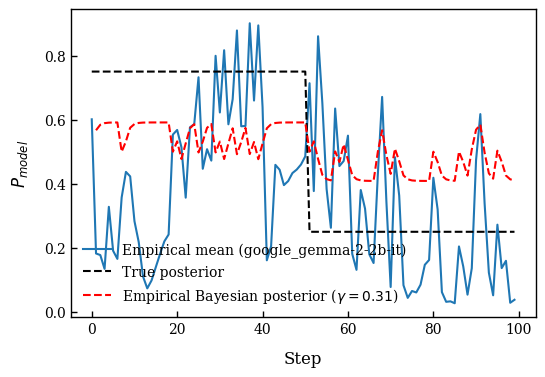

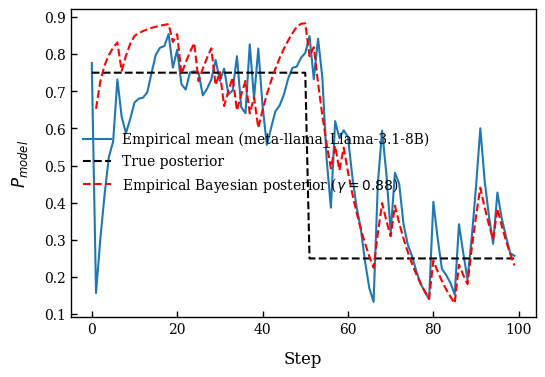

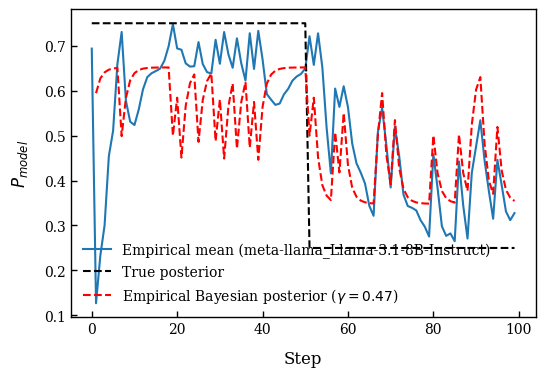

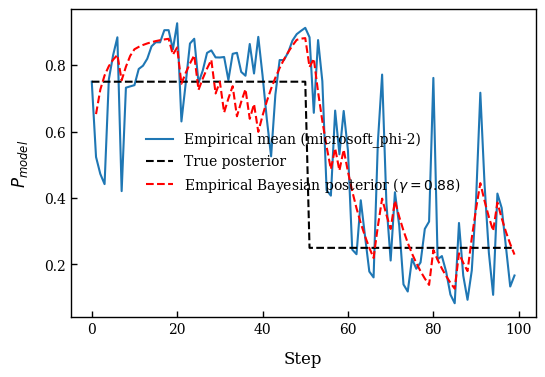

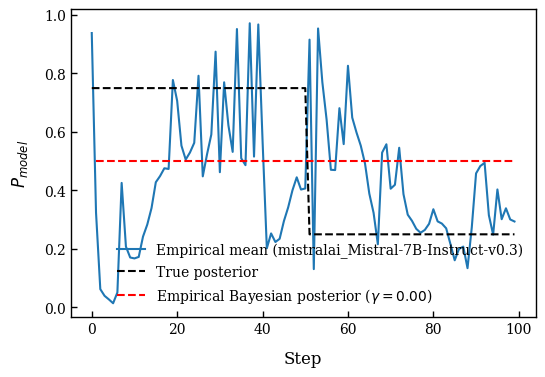

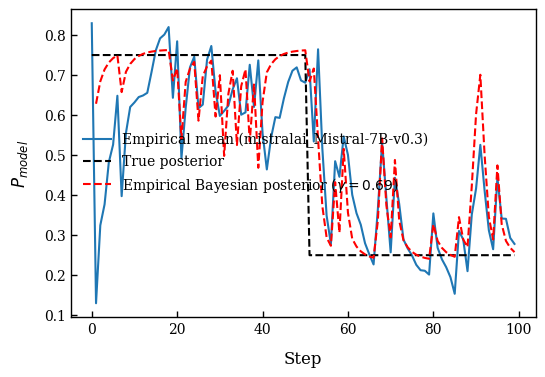

In [ ]:
# Plot the posterior for each model
for model in models:
    # Plot the data mean
    plt.plot(model_data[model]['mean'], label='Empirical mean ({})'.format(model))
    # Plot the true posterior
    plt.plot(model_data[model]['true_posterior'], color='black', linestyle='--', label='True posterior')
    # Plot the gamma decay fit
    flipper = BayesianCoinFlipperGamma(gamma=gamma_fits[model].x)
    bayes_posterior = []
    for i, s in enumerate(model_data[model]['sequence']):
        flipper.add_result(s)
        bayes_posterior.append(flipper.get_posterior_mean())

    plt.plot(np.arange(len(bayes_posterior)) + 1, bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian posterior ($\\gamma={:.2f}$)'.format(float(gamma_fits[model].x)))
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('$P_{model}$')
    plt.show()


/tmp/ipykernel_1801626/243629051.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(len(bayes_posterior)) + 1, bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian Posterior ($\\gamma={:.2f}$)'.format(float(gamma_fits[model].x)))


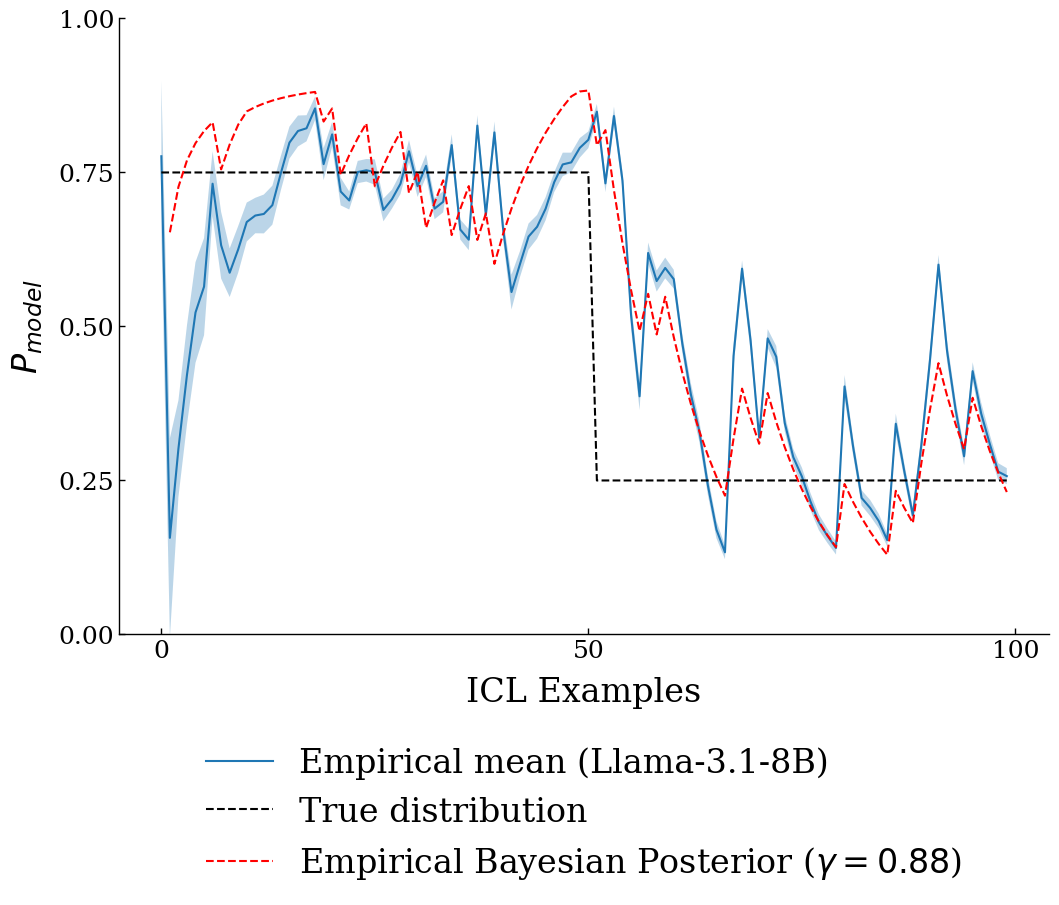

In [178]:
# Plot just meta-llama_Llama-3.1-8B

with plt.rc_context({
    'figure.figsize': (12, 8),            # Figure size
    "axes.spines.right": False,
    "axes.spines.top": False,
    'axes.titlesize': 24,                # Title font size
    'axes.labelsize': 24,                # Axis label font size
    'legend.fontsize': 24,               # Legend font size
    'xtick.labelsize': 18,               # X-axis tick label size
    'ytick.labelsize': 18,               # Y-axis tick label size
}):

    model = 'meta-llama_Llama-3.1-8B'
    # Plot the data mean
    plt.plot(model_data[model]['mean'], label='Empirical mean (Llama-3.1-8B)'.format(model))
    plt.fill_between(range(len(model_data[model]['mean'])), model_data[model]['mean'] - model_data[model]['std'], model_data[model]['mean'] + model_data[model]['std'], alpha=0.3)
    # Plot the true posterior
    plt.plot(model_data[model]['true_posterior'], color='black', linestyle='--', label='True distribution')
    # Plot the gamma decay fit
    flipper = BayesianCoinFlipperGamma(gamma=gamma_fits[model].x)
    bayes_posterior = []
    for i, s in enumerate(model_data[model]['sequence']):
        flipper.add_result(s)
        bayes_posterior.append(flipper.get_posterior_mean())

    plt.plot(np.arange(len(bayes_posterior)) + 1, bayes_posterior, color='red', linestyle='--', label='Empirical Bayesian Posterior ($\\gamma={:.2f}$)'.format(float(gamma_fits[model].x)))
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=1)
    plt.xlabel('ICL Examples')
    plt.ylabel('$P_{model}$')
    plt.ylim(0, 1.0)
    plt.xticks([0, 50, 100])
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.savefig('posterior_chain_coin_flip_meta-llama_Llama-3.1-8B.pdf')
    plt.show()